# Libraries, functions, settings

In [1]:
#Libraries

import numpy as np
import pandas as pd 
from netCDF4 import Dataset
import netCDF4
import xarray as xr
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.util as cutil
import cartopy.crs as ccrs
import nc_time_axis
import dask
from RAMIP_FWI_utilities import *

import datetime
from datetime import timedelta
import sys
from os import listdir
from datetime import datetime
import cftime
import zarr

from time import time
from numba import jit


In [3]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=40, memory_limit="20GB", threads_per_worker=1, processes=True, dashboard_address=":8894")
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:34023' processes=40 threads=40, memory=745.06 GiB>

2025-08-15 19:08:27,482 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 43c6809fc558eaf176ec4c55cd1052ec initialized by task ('rechunk-merge-rechunk-transfer-7de51cbc22ee2ca3a115d46460e164da', 1, 0, 0, 0, 2, 0, 2, 1) executed on worker tcp://127.0.0.1:43905
2025-08-15 19:08:27,518 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4f4b948bf2e94c133ec89320f8643a3b initialized by task ('rechunk-merge-rechunk-transfer-7de51cbc22ee2ca3a115d46460e164da', 5, 0, 0, 0, 7, 0, 9, 1) executed on worker tcp://127.0.0.1:42019
2025-08-15 19:08:27,588 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0bccdb43318161ed3cd40c03f4bbe3e5 initialized by task ('rechunk-merge-rechunk-transfer-7de51cbc22ee2ca3a115d46460e164da', 3, 0, 0, 0, 5, 0, 9, 1) executed on worker tcp://127.0.0.1:36395
2025-08-15 19:08:27,713 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 2d41dd0659a6510f2f81a1be84c51cf2 initialized by task ('rechunk-merge-rechunk-transfer-7de51cbc22ee2ca3a115

# Map Development

Creating example with RAMIP emission regions...


/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Creating example with specific RAMIP regions...


/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


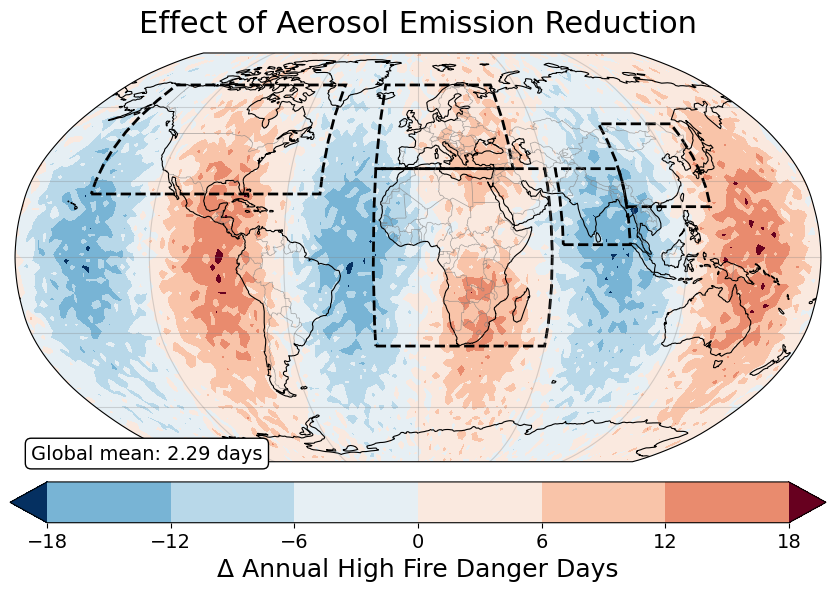

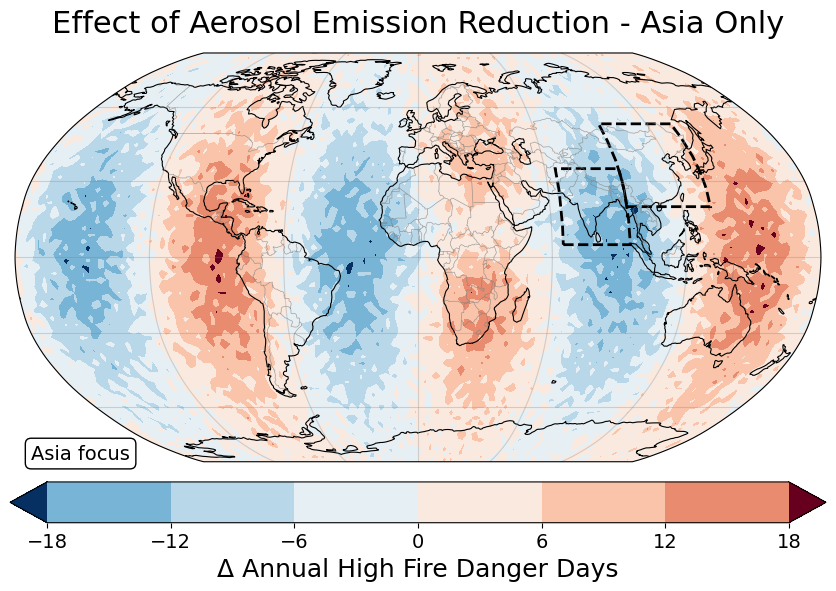

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from matplotlib.patches import Rectangle
import regionmask

def create_global_map(data, 
                     projection=ccrs.Robinson(),
                     title="Global Map",
                     colormap='RdBu_r',
                     colorbar_title="Change",
                     textbox_text=None,
                     figsize=(10.5, 6),
                     vmin=None,
                     vmax=None,
                     extend='both',
                     colorbar_levels=None,
                     contour_levels=None,
                     hatching='///',
                     regional_boundaries=True,
                     hatching_style='overlay',
                     hatching_data=None,
                     colorbar_extend=None,
                     show_gridlines=True,
                     ramip_regions=False):
    """
    Create a global map visualization similar to climate change impact maps.
    
    Parameters:
    -----------
    data : xarray.DataArray or list of xarray.DataArrays
        If DataArray: 2D DataArray with lat/lon coordinates for filled contour plot
        If list: [fill_data, contour_data] where fill_data is for colors and 
                 contour_data is for contour lines (contour_data is optional)
    projection : cartopy projection, optional
        Map projection to use (default: Robinson)
    title : str, optional
        Title for the plot (default: "Global Map")
    colormap : str, optional
        Matplotlib colormap name (default: 'RdBu_r')
    colorbar_title : str, optional
        Title for the colorbar (default: "Change")
    textbox_text : str, optional
        Text to display in the bottom-left textbox (supports f-string format)
    figsize : tuple, optional
        Figure size (width, height) in inches (default: (10.5, 6))
    vmin : float, optional
        Minimum value for color scale
    vmax : float, optional
        Maximum value for color scale
    extend : str, optional
        Colorbar extension ('both', 'min', 'max', 'neither') - DEPRECATED, use colorbar_extend
    colorbar_levels : array-like, optional
        Specific levels for the colorbar/filled contours
    contour_levels : array-like, optional
        Specific levels for contour lines
    hatching : str, optional
        Hatching pattern for masked areas (default: '///', set to None to disable)
    regional_boundaries : str or bool, optional
        Type of boundaries to show. Options: True or 'countries' (country boundaries), 
        'ar6' (IPCC AR6 WG1 reference regions), False or 'none' (no boundaries) 
        (default: True)
    hatching_style : str, optional
        How to display hatched areas: 'overlay' (hatching over colors) or 
        'white' (white background with hatching) (default: 'overlay')
    hatching_data : xarray.DataArray, optional
        Data array indicating where to apply hatching. Hatching will be applied 
        where hatching_data is NOT NaN (i.e., only over valid hatching indicator areas).
    colorbar_extend : str, optional
        Controls colorbar arrows: 'min' (arrow at bottom), 'max' 
        (arrow at top), 'both' (arrows at both ends), 'neither' (no arrows).
        If None, uses the 'extend' parameter for backward compatibility.
    show_gridlines : bool, optional
        Whether to display map gridlines (default: True)
    ramip_regions : bool, str, or list, optional
        Whether to display RAMIP emission region boxes. Options:
        - False: No RAMIP regions (default)
        - True: All 4 groups of RAMIP regions
        - 'east_asia': East Asia region only
        - 'south_asia': South Asia region only  
        - 'africa_mideast': Africa & Middle East region only
        - 'north_america_europe': North America & Europe regions only
        - list: Combination of region names, e.g. ['east_asia', 'south_asia']
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    
    Example:
    --------
    # Single dataset example with RAMIP regions
    lons = np.linspace(-180, 180, 144)
    lats = np.linspace(-90, 90, 72)
    fill_data = xr.DataArray(
        np.random.randn(72, 144) * 20,
        coords={'lat': lats, 'lon': lons},
        dims=['lat', 'lon']
    )
    
    fig, ax = create_global_map(
        data=fill_data,
        title="Effect of Aerosol Emission Reduction",
        colorbar_title="Δ Annual High Fire Danger Days",
        textbox_text="2.29 days",
        ramip_regions=True,  # Show all RAMIP regions, or specify: 'east_asia', 'south_asia', etc.
        regional_boundaries='ar6',
        show_gridlines=False
    )
    plt.show()
    """
    
    # Define RAMIP emission region boundaries (from Wilcox et al., 2023 - Figure 2)
    # East Asia
    lat_bot_eas = 20
    lat_top_eas = 53
    lon_west_eas = 95
    lon_east_eas = 133
    
    # South Asia
    lat_bot_sas = 5
    lat_top_sas = 35
    lon_west_sas = 65
    lon_east_sas = 95
    
    # Africa & Mid-East
    lat_bot_afr = -35
    lat_top_afr = 35
    lon_west_afr = 360-20  # 340
    lon_east_afr = 60
    
    # North America
    lat_bot_nam = 25
    lat_top_nam = 70
    lon_west_nam = 360-150  # 210
    lon_east_nam = 360-45   # 315
    
    # Europe
    lat_bot_eur = 35
    lat_top_eur = 70
    lon_west_eur = 360-20   # 340
    lon_east_eur = 45
    
    # Handle input data - can be single DataArray or list
    if isinstance(data, list):
        fill_data = data[0]
        contour_data = data[1] if len(data) > 1 else None
    else:
        fill_data = data
        contour_data = None
    
    # Create figure and axis with specified projection
    fig = plt.figure(figsize=figsize, facecolor='white')
    ax = plt.axes(projection=projection)
    
    # Set global extent
    ax.set_global()
    
    # Add map features - coastlines always shown
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
    
    # Add boundaries based on user selection
    if regional_boundaries is True or regional_boundaries == 'countries':
        # Show country boundaries (default behavior)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.7)
    elif regional_boundaries == 'ar6':
        # Show IPCC AR6 WG1 reference regions
        ar6_regions = regionmask.defined_regions.ar6.land
        # Use cartopy-compatible plotting
        ar6_regions.plot_regions(ax=ax, 
                                line_kws={'linewidth': 0.8, 'color': 'black', 'alpha': 0.4},
                                add_label=False)
    # If False, 'none', or any other value, no additional boundaries are added
    
    # Handle fill data coordinates - ensure they're named correctly
    if 'latitude' in fill_data.coords:
        fill_data = fill_data.rename({'latitude': 'lat'})
    if 'longitude' in fill_data.coords:
        fill_data = fill_data.rename({'longitude': 'lon'})
    
    # Determine colorbar extension
    if colorbar_extend is not None:
        # Use the new parameter (now matches matplotlib's extend options directly)
        if colorbar_extend in ['min', 'max', 'both', 'neither']:
            extend_param = colorbar_extend
        else:
            raise ValueError("colorbar_extend must be 'min', 'max', 'both', or 'neither'")
    else:
        # Fall back to the old extend parameter for backward compatibility
        extend_param = extend
    
    # Set color limits if not provided
    if vmin is None or vmax is None:
        data_range = np.nanmax(np.abs(fill_data.values))
        if vmin is None:
            vmin = -data_range
        if vmax is None:
            vmax = data_range
    
    # Create the main filled contour plot using contourf
    if colorbar_levels is not None:
        # Use provided levels
        im = ax.contourf(fill_data.lon, fill_data.lat, fill_data.values, 
                        levels=colorbar_levels,
                        transform=ccrs.PlateCarree(),
                        cmap=colormap,
                        vmin=vmin, 
                        vmax=vmax,
                        extend=extend_param)
    else:
        # Generate automatic levels for contourf
        im = ax.contourf(fill_data.lon, fill_data.lat, fill_data.values,
                        transform=ccrs.PlateCarree(),
                        cmap=colormap,
                        vmin=vmin, 
                        vmax=vmax,
                        extend=extend_param)
    
    # Add contour lines if contour data is provided
    if contour_data is not None:
        # Handle contour data coordinates
        if 'latitude' in contour_data.coords:
            contour_data = contour_data.rename({'latitude': 'lat'})
        if 'longitude' in contour_data.coords:
            contour_data = contour_data.rename({'longitude': 'lon'})
        
        # Create contour lines
        if contour_levels is not None:
            cs = ax.contour(contour_data.lon, contour_data.lat, contour_data.values,
                           levels=contour_levels,
                           transform=ccrs.PlateCarree(),
                           colors='black',
                           linewidths=0.8,
                           alpha=0.7)
        else:
            cs = ax.contour(contour_data.lon, contour_data.lat, contour_data.values,
                           transform=ccrs.PlateCarree(),
                           colors='black',
                           linewidths=0.8,
                           alpha=0.7)
        
        # Optionally add contour labels
        ax.clabel(cs, inline=True, fontsize=8, fmt='%g')
    
    # Add hatching only where hatching_data specifies
    if hatching is not None and hatching_data is not None:
        # Handle coordinates for hatching data
        if 'latitude' in hatching_data.coords:
            hatching_data = hatching_data.rename({'latitude': 'lat'})
        if 'longitude' in hatching_data.coords:
            hatching_data = hatching_data.rename({'longitude': 'lon'})
        
        # Create hatching mask that uses hatching_data 
        hatching_data_valid = ~np.isnan(hatching_data.values)  # True where hatching_data is not NaN
        hatch_mask = hatching_data_valid 
        
        if np.any(hatch_mask):
            # Create meshgrid for hatching
            X, Y = np.meshgrid(hatching_data.lon, hatching_data.lat)
            
            if hatching_style == 'overlay':
                # Overlay hatching (shows colors underneath)
                ax.contourf(X, Y, hatch_mask.astype(int), 
                           levels=[0.5, 1.5], 
                           colors='none', 
                           hatches=[hatching], 
                           transform=ccrs.PlateCarree())
            elif hatching_style == 'white':
                # White areas with hatching (covers the filled contours)
                ax.contourf(X, Y, hatch_mask.astype(int),
                           levels=[0.5, 1.5], 
                           colors=['white'],
                           hatches=[hatching],
                           transform=ccrs.PlateCarree(),
                           alpha=1.0,
                           zorder=5)
    
    # Add RAMIP emission region boxes
    if ramip_regions:
        # Determine which regions to show
        regions_to_show = []
        
        if ramip_regions is True:
            # Show all regions
            regions_to_show = ['east_asia', 'south_asia', 'africa_mideast', 'north_america_europe']
        elif isinstance(ramip_regions, str):
            # Single region specified
            regions_to_show = [ramip_regions]
        elif isinstance(ramip_regions, (list, tuple)):
            # Multiple regions specified
            regions_to_show = list(ramip_regions)
        
        # Draw the specified regions
        for region in regions_to_show:
            if region == 'east_asia':
                # East Asia
                ax.add_patch(mpatches.Rectangle(
                    xy=[lon_west_eas, lat_bot_eas], 
                    width=(lon_east_eas - lon_west_eas), 
                    height=(lat_top_eas - lat_bot_eas),
                    facecolor='none',
                    linestyle='--',
                    linewidth=2.0,
                    edgecolor='black',
                    alpha=1,
                    transform=ccrs.PlateCarree())
                )
            
            elif region == 'south_asia':
                # South Asia
                ax.add_patch(mpatches.Rectangle(
                    xy=[lon_west_sas, lat_bot_sas], 
                    width=(lon_east_sas - lon_west_sas), 
                    height=(lat_top_sas - lat_bot_sas),
                    facecolor='none',
                    linestyle='--',
                    linewidth=2.0,
                    edgecolor='black',
                    alpha=1,
                    transform=ccrs.PlateCarree())
                )
            
            elif region == 'africa_mideast':
                # Africa & Mid-East (crosses dateline) - use single rectangle with proper wrapping
                ax.add_patch(mpatches.Rectangle(
                    xy=[lon_west_afr, lat_bot_afr], 
                    width=(lon_east_afr + (360 - lon_west_afr)), 
                    height=(lat_top_afr - lat_bot_afr),
                    facecolor='none',
                    linestyle='--',
                    linewidth=2.0,
                    edgecolor='black',
                    alpha=1,
                    transform=ccrs.PlateCarree())
                )
            
            elif region == 'north_america_europe':
                # North America
                ax.add_patch(mpatches.Rectangle(
                    xy=[lon_west_nam, lat_bot_nam], 
                    width=(lon_east_nam - lon_west_nam), 
                    height=(lat_top_nam - lat_bot_nam),
                    facecolor='none',
                    linestyle='--',
                    linewidth=2.0,
                    edgecolor='black',
                    alpha=1,
                    transform=ccrs.PlateCarree())
                )
                
                # Europe (crosses dateline) - use single rectangle with proper wrapping
                ax.add_patch(mpatches.Rectangle(
                    xy=[lon_west_eur, lat_bot_eur], 
                    width=(lon_east_eur + (360 - lon_west_eur)), 
                    height=(lat_top_eur - lat_bot_eur),
                    facecolor='none',
                    linestyle='--',
                    linewidth=2.0,
                    edgecolor='black',
                    alpha=1,
                    transform=ccrs.PlateCarree())
                )
    
    # Add gridlines conditionally
    if show_gridlines:
        gl = ax.gridlines(draw_labels=False, linestyle='-', alpha=0.3, color='gray')
    
    # Create colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
                       pad=0.04, shrink=0.8, aspect=20,
                       extend=extend_param)
    cbar.set_label(colorbar_title, fontsize=18, fontweight='regular')
    cbar.ax.tick_params(labelsize=14)
    
    # Add title
    plt.title(title, fontsize=22, fontweight='regular', pad=15)
    
    # Add textbox in bottom-left corner if text is provided
    if textbox_text is not None:
        # Add white background rectangle
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white', 
                         edgecolor='black', linewidth=1.0)
        
        ax.text(0.02, 0.02, textbox_text, transform=ax.transAxes,
                fontsize=14, fontweight='regular',
                verticalalignment='center', horizontalalignment='left',
                bbox=bbox_props, zorder=10)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax


# Example usage and demonstration
if __name__ == "__main__":
    # Create sample data
    lons = np.linspace(-180, 180, 144)
    lats = np.linspace(-90, 90, 72)
    
    # Create synthetic fill data (fire danger days)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    fill_values = np.zeros_like(lat_grid)
    fill_values += 15 * np.exp(-(lat_grid/60)**2) * np.sin(lon_grid * np.pi / 60)
    fill_values += -10 * np.exp(-((lat_grid-10)/20)**2 - ((lon_grid-30)/40)**2)
    fill_values += np.random.randn(*fill_values.shape) * 3
    
    # Create xarray DataArray
    fill_data = xr.DataArray(
        fill_values,
        coords={'lat': lats, 'lon': lons},
        dims=['lat', 'lon'],
        name='fire_danger_change'
    )
    
    # Example with RAMIP regions
    print("Creating example with RAMIP emission regions...")
    fig, ax = create_global_map(
        data=fill_data,
        title="Effect of Aerosol Emission Reduction",
        colorbar_title="Δ Annual High Fire Danger Days",
        textbox_text="Global mean: 2.29 days",
        vmin=-32,
        vmax=32,
        ramip_regions=True,  # Show all RAMIP emission region groups
        regional_boundaries='countries',
        colorbar_extend='both',
        show_gridlines=True
    )
    
    # Example with specific RAMIP regions
    print("Creating example with specific RAMIP regions...")
    fig2, ax2 = create_global_map(
        data=fill_data,
        title="Effect of Aerosol Emission Reduction - Asia Only",
        colorbar_title="Δ Annual High Fire Danger Days", 
        textbox_text="Asia focus",
        vmin=-32,
        vmax=32,
        ramip_regions=['east_asia', 'south_asia'],  # Show only Asian regions
        regional_boundaries='countries',
        colorbar_extend='both',
        show_gridlines=True
    )
    
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from matplotlib.patches import Rectangle
import regionmask

def create_global_map_grid(data_list, 
                          rows=2, 
                          cols=2,
                          main_title="Global Map Grid",
                          projection=ccrs.Robinson(),
                          titles=None,
                          colormaps='RdBu_r',
                          colorbar_titles="Change",
                          textbox_texts=None,
                          figsize=None,
                          vmins=None,
                          vmaxs=None,
                          extends='both',
                          colorbar_levels=None,
                          contour_levels=None,
                          hatchings='///',
                          regional_boundaries=True,
                          hatching_styles='overlay',
                          hatching_data=None,
                          show_gridlines=True,
                          ramip_regions=False,
                          subplot_spacing={'hspace': 0.3, 'wspace': 0.1},
                          colorbar_spacing=0.05):
    """
    Create a grid of global map visualizations similar to climate change impact maps.
    
    Parameters:
    -----------
    data_list : list
        List of data for each subplot. Each item can be:
        - xarray.DataArray: 2D DataArray with lat/lon coordinates for filled contour plot
        - tuple/list: (fill_data, contour_data) where fill_data is for colors and 
                      contour_data is for contour lines
    rows : int
        Number of rows in the grid (default: 2)
    cols : int  
        Number of columns in the grid (default: 2)
    main_title : str, optional
        Main title for the entire grid (default: "Global Map Grid")
    projection : cartopy projection or list, optional
        Map projection(s) to use. Can be single projection for all maps or list of projections
    titles : str or list, optional
        Title(s) for individual subplots. Can be single string or list
    colormaps : str or list, optional
        Colormap(s) to use. Can be single colormap or list (default: 'RdBu_r')
    colorbar_titles : str or list, optional
        Title(s) for colorbars. Can be single string or list (default: "Change")
    textbox_texts : str, list, or None, optional
        Text(s) for textboxes in subplots. Can be single string, list, or None
    figsize : tuple, optional
        Figure size (width, height) in inches. If None, auto-calculated based on grid size
    vmins : float or list, optional
        Minimum value(s) for color scale. Can be single value or list
    vmaxs : float or list, optional  
        Maximum value(s) for color scale. Can be single value or list
    extends : str or list, optional
        Colorbar extension(s): 'min', 'max', 'both', 'neither'. Can be single value or list
    colorbar_levels : array-like or list, optional
        Specific level(s) for colorbars. Can be single array or list of arrays
    contour_levels : array-like or list, optional
        Specific level(s) for contour lines. Can be single array or list of arrays
    hatchings : str or list, optional
        Hatching pattern(s). Can be single pattern or list (default: '///')
    regional_boundaries : str, bool, or list, optional
        Boundary type(s) to show. Can be single value or list
    hatching_styles : str or list, optional
        Hatching style(s). Can be single style or list (default: 'overlay')
    hatching_data : xarray.DataArray, list, or None, optional
        Hatching data for each subplot. Can be single DataArray, list, or None
    extends : str or list, optional
        Colorbar extension(s): 'min', 'max', 'both', 'neither'. Can be single value or list
    show_gridlines : bool or list, optional
        Whether to show gridlines. Can be single bool or list (default: True)
    ramip_regions : bool, str, list, or list of lists, optional
        RAMIP regions to show. Can be single value or list of values for each subplot
    subplot_spacing : dict, optional
        Spacing parameters for subplots: {'hspace': vertical, 'wspace': horizontal}
    colorbar_spacing : float, optional
        Additional space below each subplot for colorbar (default: 0.05)
        
    Returns:
    --------
    fig : matplotlib figure object
    axes : array of matplotlib axis objects
    
    Example:
    --------
    # Create sample data
    lons = np.linspace(-180, 180, 144)
    lats = np.linspace(-90, 90, 72)
    
    data1 = xr.DataArray(np.random.randn(72, 144) * 20,
                        coords={'lat': lats, 'lon': lons}, dims=['lat', 'lon'])
    data2 = xr.DataArray(np.random.randn(72, 144) * 15,
                        coords={'lat': lats, 'lon': lons}, dims=['lat', 'lon'])
    data3 = xr.DataArray(np.random.randn(72, 144) * 25,
                        coords={'lat': lats, 'lon': lons}, dims=['lat', 'lon'])
    data4 = xr.DataArray(np.random.randn(72, 144) * 10,
                        coords={'lat': lats, 'lon': lons}, dims=['lat', 'lon'])
    
    # Example with 5 maps in 2 columns (3 rows)
    fig, axes = create_global_map_grid(
        data_list=[data1, data2, data3, data4, data5],
        rows=3, cols=2,  # 6 subplot positions, but only 5 maps (last position will be empty)
        main_title="Fire Weather Changes - 5 Scenarios",
        titles=["Scenario A", "Scenario B", "Scenario C", "Scenario D", "Scenario E"]
    )
    plt.show()
    """
    
    # Validate inputs
    n_plots = len(data_list)
    max_plots = rows * cols
    if n_plots > max_plots:
        raise ValueError(f"Number of data items ({n_plots}) exceeds grid capacity ({max_plots})")
    if n_plots == 0:
        raise ValueError("data_list cannot be empty")
    
    # Helper function to convert single values to lists
    def _ensure_list(param, default_val, n_items):
        if param is None:
            return [default_val] * n_items
        elif isinstance(param, (list, tuple)):
            # It's a list/tuple - check if it's meant to be per-subplot or single value
            if len(param) == n_items:
                return list(param)
            elif len(param) == 1:
                return [param[0]] * n_items
            else:
                raise ValueError(f"Parameter list length ({len(param)}) must be either 1 or {n_items}")
        elif isinstance(param, np.ndarray):
            # For numpy arrays, treat as single parameter to be applied to all subplots
            return [param] * n_items
        else:
            # Single value - apply to all subplots
            return [param] * n_items
    
    # Convert all parameters to lists
    projections = _ensure_list(projection, ccrs.Robinson(), n_plots)
    title_list = _ensure_list(titles, "Global Map", n_plots)
    colormap_list = _ensure_list(colormaps, 'RdBu_r', n_plots)
    colorbar_title_list = _ensure_list(colorbar_titles, "Change", n_plots)
    textbox_text_list = _ensure_list(textbox_texts, None, n_plots)
    vmin_list = _ensure_list(vmins, None, n_plots)
    vmax_list = _ensure_list(vmaxs, None, n_plots)
    extend_list = _ensure_list(extends, 'both', n_plots)
    colorbar_level_list = _ensure_list(colorbar_levels, None, n_plots)
    contour_level_list = _ensure_list(contour_levels, None, n_plots)
    hatching_list = _ensure_list(hatchings, '///', n_plots)
    regional_boundary_list = _ensure_list(regional_boundaries, True, n_plots)
    hatching_style_list = _ensure_list(hatching_styles, 'overlay', n_plots)
    hatching_data_list = _ensure_list(hatching_data, None, n_plots)
    show_gridlines_list = _ensure_list(show_gridlines, True, n_plots)
    ramip_regions_list = _ensure_list(ramip_regions, False, n_plots)
    
    # Calculate figure size if not provided
    if figsize is None:
        # Base size per subplot, adjusted for colorbars and spacing
        base_width = 5.0
        base_height = 3.5
        figsize = (cols * base_width, rows * (base_height + colorbar_spacing * 8))
    
    # Create figure and subplots
    fig = plt.figure(figsize=figsize, facecolor='white')
    
    # Calculate subplot positions to leave room for individual colorbars
    subplot_height = (1.0 - subplot_spacing['hspace']) / rows - colorbar_spacing
    subplot_width = (1.0 - subplot_spacing['wspace']) / cols
    
    axes = []
    
    for i in range(n_plots):
        row = i // cols
        col = i % cols
        
        # Calculate subplot position
        left = col * (subplot_width + subplot_spacing['wspace'] / cols) + subplot_spacing['wspace'] / (2 * cols)
        bottom = (rows - row - 1) * (subplot_height + colorbar_spacing + subplot_spacing['hspace'] / rows) + colorbar_spacing + subplot_spacing['hspace'] / (2 * rows)
        
        # Create subplot with cartopy projection
        ax = fig.add_subplot(rows, cols, i + 1, projection=projections[i])
        axes.append(ax)
        
        # Get current data
        current_data = data_list[i]
        
        # Handle input data - can be single DataArray or tuple/list
        if isinstance(current_data, (list, tuple)):
            fill_data = current_data[0]
            contour_data = current_data[1] if len(current_data) > 1 else None
        else:
            fill_data = current_data
            contour_data = None
        
        # Set global extent
        ax.set_global()
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6, color='black')
        
        # Add boundaries based on user selection
        current_boundaries = regional_boundary_list[i]
        if current_boundaries is True or current_boundaries == 'countries':
            ax.add_feature(cfeature.BORDERS, linewidth=0.3, color='gray', alpha=0.7)
        elif current_boundaries == 'ar6':
            ar6_regions = regionmask.defined_regions.ar6.land
            ar6_regions.plot_regions(ax=ax, 
                                   line_kws={'linewidth': 0.6, 'color': 'black', 'alpha': 0.4},
                                   add_label=False)
        
        # Handle fill data coordinates
        if 'latitude' in fill_data.coords:
            fill_data = fill_data.rename({'latitude': 'lat'})
        if 'longitude' in fill_data.coords:
            fill_data = fill_data.rename({'longitude': 'lon'})
        
        # Use extends parameter directly
        extend_param = extend_list[i]
        
        # Set color limits
        vmin = vmin_list[i]
        vmax = vmax_list[i]
        if vmin is None or vmax is None:
            data_range = np.nanmax(np.abs(fill_data.values))
            if vmin is None:
                vmin = -data_range
            if vmax is None:
                vmax = data_range
        
        # Create filled contour plot
        if colorbar_level_list[i] is not None:
            im = ax.contourf(fill_data.lon, fill_data.lat, fill_data.values, 
                           levels=colorbar_level_list[i],
                           transform=ccrs.PlateCarree(),
                           cmap=colormap_list[i],
                           vmin=vmin, vmax=vmax,
                           extend=extend_param)
        else:
            im = ax.contourf(fill_data.lon, fill_data.lat, fill_data.values,
                           transform=ccrs.PlateCarree(),
                           cmap=colormap_list[i],
                           vmin=vmin, vmax=vmax,
                           extend=extend_param)
        
        # Add contour lines if contour data is provided
        if contour_data is not None:
            if 'latitude' in contour_data.coords:
                contour_data = contour_data.rename({'latitude': 'lat'})
            if 'longitude' in contour_data.coords:
                contour_data = contour_data.rename({'longitude': 'lon'})
            
            if contour_level_list[i] is not None:
                cs = ax.contour(contour_data.lon, contour_data.lat, contour_data.values,
                               levels=contour_level_list[i],
                               transform=ccrs.PlateCarree(),
                               colors='black', linewidths=0.6, alpha=0.7)
            else:
                cs = ax.contour(contour_data.lon, contour_data.lat, contour_data.values,
                               transform=ccrs.PlateCarree(),
                               colors='black', linewidths=0.6, alpha=0.7)
            ax.clabel(cs, inline=True, fontsize=6, fmt='%g')
        
        # Add hatching
        if hatching_list[i] is not None and hatching_data_list[i] is not None:
            hatch_data = hatching_data_list[i]
            if 'latitude' in hatch_data.coords:
                hatch_data = hatch_data.rename({'latitude': 'lat'})
            if 'longitude' in hatch_data.coords:
                hatch_data = hatch_data.rename({'longitude': 'lon'})
            
            hatching_data_valid = ~np.isnan(hatch_data.values)
            hatch_mask = hatching_data_valid
            
            if np.any(hatch_mask):
                X, Y = np.meshgrid(hatch_data.lon, hatch_data.lat)
                if hatching_style_list[i] == 'overlay':
                    ax.contourf(X, Y, hatch_mask.astype(int), 
                               levels=[0.5, 1.5], colors='none', 
                               hatches=[hatching_list[i]], 
                               transform=ccrs.PlateCarree())
                elif hatching_style_list[i] == 'white':
                    ax.contourf(X, Y, hatch_mask.astype(int),
                               levels=[0.5, 1.5], colors=['white'],
                               hatches=[hatching_list[i]],
                               transform=ccrs.PlateCarree(),
                               alpha=1.0, zorder=5)
        
        # Add RAMIP regions (copied from original function)
        current_ramip = ramip_regions_list[i]
        if current_ramip:
            # RAMIP region definitions
            regions_coords = {
                'east_asia': {'lon_west': 95, 'lon_east': 133, 'lat_bot': 20, 'lat_top': 53},
                'south_asia': {'lon_west': 65, 'lon_east': 95, 'lat_bot': 5, 'lat_top': 35},
                'africa_mideast': {'lon_west': 340, 'lon_east': 60, 'lat_bot': -35, 'lat_top': 35},
                'north_america': {'lon_west': 210, 'lon_east': 315, 'lat_bot': 25, 'lat_top': 70},
                'europe': {'lon_west': 340, 'lon_east': 45, 'lat_bot': 35, 'lat_top': 70}
            }
            
            # Determine regions to show
            regions_to_show = []
            if current_ramip is True:
                regions_to_show = ['east_asia', 'south_asia', 'africa_mideast', 'north_america', 'europe']
            elif isinstance(current_ramip, str):
                if current_ramip == 'north_america_europe':
                    regions_to_show = ['north_america', 'europe']
                else:
                    regions_to_show = [current_ramip]
            elif isinstance(current_ramip, (list, tuple)):
                for region in current_ramip:
                    if region == 'north_america_europe':
                        regions_to_show.extend(['north_america', 'europe'])
                    else:
                        regions_to_show.append(region)
            
            # Draw regions
            for region in regions_to_show:
                if region in regions_coords:
                    coords = regions_coords[region]
                    if region in ['africa_mideast', 'europe']:  # Handle dateline crossing
                        width = coords['lon_east'] + (360 - coords['lon_west'])
                    else:
                        width = coords['lon_east'] - coords['lon_west']
                    
                    ax.add_patch(mpatches.Rectangle(
                        xy=[coords['lon_west'], coords['lat_bot']], 
                        width=width,
                        height=(coords['lat_top'] - coords['lat_bot']),
                        facecolor='none', linestyle='--', linewidth=1.5,
                        edgecolor='black', alpha=1,
                        transform=ccrs.PlateCarree()))
        
        # Add gridlines
        if show_gridlines_list[i]:
            ax.gridlines(draw_labels=False, linestyle='-', alpha=0.3, color='gray')
        
        # Create individual colorbar for each subplot
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
                           pad=0.08, shrink=0.8, aspect=15,
                           extend=extend_param)
        cbar.set_label(colorbar_title_list[i], fontsize=10)
        cbar.ax.tick_params(labelsize=8)
        
        # Add subplot title
        ax.set_title(title_list[i], fontsize=12, pad=10)
        
        # Add textbox if provided
        if textbox_text_list[i] is not None:
            bbox_props = dict(boxstyle="round,pad=0.2", facecolor='white', 
                            edgecolor='black', linewidth=0.8)
            ax.text(0.02, 0.02, textbox_text_list[i], transform=ax.transAxes,
                   fontsize=10, verticalalignment='center', horizontalalignment='left',
                   bbox=bbox_props, zorder=10)
    
    # Add main title
    fig.suptitle(main_title, fontsize=16, fontweight='regular', y=0.95)
    
    # Hide any unused subplots
    total_subplots = rows * cols
    for i in range(n_plots, total_subplots):
        ax_unused = fig.add_subplot(rows, cols, i + 1)
        ax_unused.set_visible(False)
    
    # Adjust layout
    plt.subplots_adjust(**subplot_spacing)
    
    return fig, axes

# FWI Data

In [ ]:
# Open FWI data

# NorESM2-LM
noresm2_historical_fwi = read_zarr('NorESM2-LM', 'historical', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(1961, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(1990, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_ssp370_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp370', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_global_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_ssp126_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp126', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_eas_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-eas126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_sas_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-sas126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_afr_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-afr126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

noresm2_nae_fwi_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-nae126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

# SPEAR
spear_historical_fwi = read_zarr('SPEAR', 'historical', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(1961, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(1990, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_ssp370_fwi_2041_2050 = read_zarr('SPEAR', 'ssp370', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_global_fwi_2041_2050 = read_zarr('SPEAR', 'ssp370-126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_ssp126_fwi_2041_2050 = read_zarr('SPEAR', 'ssp126', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_eas_fwi_2041_2050 = read_zarr('SPEAR', 'ssp370-eas126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_sas_fwi_2041_2050 = read_zarr('SPEAR', 'ssp370-sas126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_afr_fwi_2041_2050 = read_zarr('SPEAR', 'ssp370-afr126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

spear_nae_fwi_2041_2050 = read_zarr('SPEAR', 'ssp370-nae126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

# MRI-ESM2-0
mri_historical_fwi = read_zarr('MRI-ESM2-0', 'historical', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(1961, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(1990, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_ssp370_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_global_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_ssp126_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp126', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_eas_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-eas126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_sas_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-sas126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_afr_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-afr126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

mri_nae_fwi_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-nae126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = noresm2_global_fwi_2041_2050.lat, lon = noresm2_global_fwi_2041_2050.lon)

# High Fire Danger Frequency Analysis

## General Calculation

In [23]:
# Set threshold to define high fire danger days

threshold_fwi_abs = xr.DataArray(
    data   = np.full(shape = (len(noresm2_global_fwi_2041_2050.lat.values), len(noresm2_global_fwi_2041_2050.lon.values)), fill_value = 30),  
    dims   = ['lat', 'lon'],
    coords = {'lat': noresm2_global_fwi_2041_2050.lat.values, 'lon': noresm2_global_fwi_2041_2050.lon.values},
    attrs  = {
        'long_name': 'Fire Weather Index',
        'units'     : 'unitless'
                    }
                    )


In [24]:
# Get boolean arrays where experiment values meet/exceed 30 threshold
# Broadcasting will automatically align the lat/lon dimensions

noresm2_historical_hfd_boolean = (noresm2_historical_fwi > threshold_fwi_abs).persist()
spear_historical_hfd_boolean = (spear_historical_fwi > threshold_fwi_abs).persist()
mri_historical_hfd_boolean = (mri_historical_fwi > threshold_fwi_abs).persist()
print(f"historical done")

noresm2_ssp370_hfd_boolean = (noresm2_ssp370_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_ssp370_hfd_boolean = (spear_ssp370_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_ssp370_hfd_boolean = (mri_ssp370_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"ssp370 done")

noresm2_global_hfd_boolean = (noresm2_global_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_global_hfd_boolean = (spear_global_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_global_hfd_boolean = (mri_global_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"global done")

noresm2_ssp126_hfd_boolean = (noresm2_ssp126_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_ssp126_hfd_boolean = (spear_ssp126_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_ssp126_hfd_boolean = (mri_ssp126_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"ssp126 done")

noresm2_eas_hfd_boolean = (noresm2_eas_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_eas_hfd_boolean = (spear_eas_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_eas_hfd_boolean = (mri_eas_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"eas done")

noresm2_sas_hfd_boolean = (noresm2_sas_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_sas_hfd_boolean = (spear_sas_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_sas_hfd_boolean = (mri_sas_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"sas done")

noresm2_afr_hfd_boolean = (noresm2_afr_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_afr_hfd_boolean = (spear_afr_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_afr_hfd_boolean = (mri_afr_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"afr done")

noresm2_nae_hfd_boolean = (noresm2_nae_fwi_2041_2050 > threshold_fwi_abs).persist()
spear_nae_hfd_boolean = (spear_nae_fwi_2041_2050 > threshold_fwi_abs).persist()
mri_nae_hfd_boolean = (mri_nae_fwi_2041_2050 > threshold_fwi_abs).persist()
print(f"nae done")


historical done
ssp370 done
global done
ssp126 done
eas done
sas done
afr done
nae done


In [25]:
# Get annual frequency

noresm2_historical_hfd_annual_count = noresm2_historical_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_historical_hfd_annual_count = spear_historical_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_historical_hfd_annual_count = mri_historical_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for historical")

noresm2_ssp370_hfd_annual_count = noresm2_ssp370_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_ssp370_hfd_annual_count = spear_ssp370_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_ssp370_hfd_annual_count = mri_ssp370_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for ssp370")

noresm2_global_hfd_annual_count = noresm2_global_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_global_hfd_annual_count = spear_global_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_global_hfd_annual_count = mri_global_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for global")

noresm2_ssp126_hfd_annual_count = noresm2_ssp126_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_ssp126_hfd_annual_count = spear_ssp126_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_ssp126_hfd_annual_count = mri_ssp126_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for ssp126")

noresm2_eas_hfd_annual_count = noresm2_eas_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_eas_hfd_annual_count = spear_eas_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_eas_hfd_annual_count = mri_eas_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for eas")

noresm2_sas_hfd_annual_count = noresm2_sas_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_sas_hfd_annual_count = spear_sas_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_sas_hfd_annual_count = mri_sas_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for sas")

noresm2_afr_hfd_annual_count = noresm2_afr_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_afr_hfd_annual_count = spear_afr_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_afr_hfd_annual_count = mri_afr_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for afr")

noresm2_nae_hfd_annual_count = noresm2_nae_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
spear_nae_hfd_annual_count = spear_nae_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
mri_nae_hfd_annual_count = mri_nae_hfd_boolean.resample(time='Y').sum(skipna = True).mean(dim=['time','member'])
print(f"Finished counting exceedance days for nae")


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Finished counting exceedance days for historical
Finished counting exceedance days for ssp370


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Finished counting exceedance days for global
Finished counting exceedance days for ssp126


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Finished counting exceedance days for eas
Finished counting exceedance days for sas


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Finished counting exceedance days for afr
Finished counting exceedance days for nae


In [26]:
# Concatenate from multiple models

multi_historical_hfd_annual_count = xr.concat([noresm2_historical_hfd_annual_count, spear_historical_hfd_annual_count, mri_historical_hfd_annual_count], dim="model")
multi_ssp370_hfd_annual_count = xr.concat([noresm2_ssp370_hfd_annual_count, spear_ssp370_hfd_annual_count, mri_ssp370_hfd_annual_count], dim="model")
multi_global_hfd_annual_count = xr.concat([noresm2_global_hfd_annual_count, spear_global_hfd_annual_count, mri_global_hfd_annual_count], dim="model")
multi_ssp126_hfd_annual_count = xr.concat([noresm2_ssp126_hfd_annual_count, spear_ssp126_hfd_annual_count, mri_ssp126_hfd_annual_count], dim="model")

multi_eas_hfd_annual_count = xr.concat([noresm2_eas_hfd_annual_count, spear_eas_hfd_annual_count, mri_eas_hfd_annual_count], dim="model")
multi_sas_hfd_annual_count = xr.concat([noresm2_sas_hfd_annual_count, spear_sas_hfd_annual_count, mri_sas_hfd_annual_count], dim="model")
multi_afr_hfd_annual_count = xr.concat([noresm2_afr_hfd_annual_count, spear_afr_hfd_annual_count, mri_afr_hfd_annual_count], dim="model")
multi_nae_hfd_annual_count = xr.concat([noresm2_nae_hfd_annual_count, spear_nae_hfd_annual_count, mri_nae_hfd_annual_count], dim="model")

# Compute values into memory

historical_hfd_annual_count = multi_historical_hfd_annual_count.compute()
print(f"historical_hfd_annual_count is ready")
ssp370_hfd_annual_count = multi_ssp370_hfd_annual_count.compute()
print(f"ssp370_fwi_95th_annual_count is ready")
global_hfd_annual_count = multi_global_hfd_annual_count.compute()
print(f"global_hfd_annual_count is ready")
ssp126_hfd_annual_count = multi_ssp126_hfd_annual_count.compute()
print(f"ssp126_fwi_95th_annual_count is ready")

eas_hfd_annual_count = multi_eas_hfd_annual_count.compute()
print(f"eas_hfd_annual_count is ready")
sas_hfd_annual_count = multi_sas_hfd_annual_count.compute()
print(f"sas_hfd_annual_count is ready")
afr_hfd_annual_count = multi_afr_hfd_annual_count.compute()
print(f"afr_hfd_annual_count is ready")
nae_hfd_annual_count = multi_nae_hfd_annual_count.compute()
print(f"nae_hfd_annual_count is ready")


historical_hfd_annual_count is ready
ssp370_fwi_95th_annual_count is ready
global_hfd_annual_count is ready
ssp126_fwi_95th_annual_count is ready
eas_hfd_annual_count is ready
sas_hfd_annual_count is ready
afr_hfd_annual_count is ready
nae_hfd_annual_count is ready


## Climatology

In [27]:
# Apply masks for filled contour on maps and global average value (textbox on maps)
# Non-barren land

historical_hfd_annual_count_masked, _ = apply_masks(historical_hfd_annual_count, 
                                                             get_significance=False,    
                                                             get_land_mask=True,
                                                             baseline_data=None)

# ssp370_hfd_annual_count_masked, _ = apply_masks(ssp370_hfd_annual_count, 
#                                                          get_significance=False, 
#                                                          get_land_mask=True,
#                                                          baseline_data=None)

# global_hfd_annual_count_masked, _ = apply_masks(global_hfd_annual_count, 
#                                                          get_significance=False, 
#                                                          get_land_mask=True,
#                                                          baseline_data=None)

# ssp126_hfd_annual_count_masked, _ = apply_masks(ssp126_hfd_annual_count, 
#                                                          get_significance=False, 
#                                                          get_land_mask=True,
#                                                          baseline_data=None)

# eas_hfd_annual_count_masked, _ = apply_masks(eas_hfd_annual_count, 
#                                                          get_significance=False, 
#                                                          get_land_mask=True,
#                                                          baseline_data=None)

# sas_hfd_annual_count_masked, _ = apply_masks(sas_hfd_annual_count, 
#                                                       get_significance=False, 
#                                                       get_land_mask=True,
#                                                       baseline_data=None)

# afr_hfd_annual_count_masked, _ = apply_masks(afr_hfd_annual_count, 
#                                                       get_significance=False, 
#                                                       get_land_mask=True,
#                                                       baseline_data=None)

# nae_hfd_annual_count_masked, _ = apply_masks(nae_hfd_annual_count, 
#                                                       get_significance=False,
#                                                       get_land_mask=True,
#                                                       baseline_data=None)

In [28]:
# Get latitudinally weighted global average
# Non-barren land

historical_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(historical_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)
# ssp370_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(ssp370_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)
# global_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(global_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)
# ssp126_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(ssp126_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)

# eas_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(eas_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)
# sas_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(sas_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)
# afr_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(afr_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)
# nae_hfd_annual_count_masked_globalavg = weighted_horizontal_avg(nae_hfd_annual_count_masked.mean('model'), ensemble = False, time = False)


/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


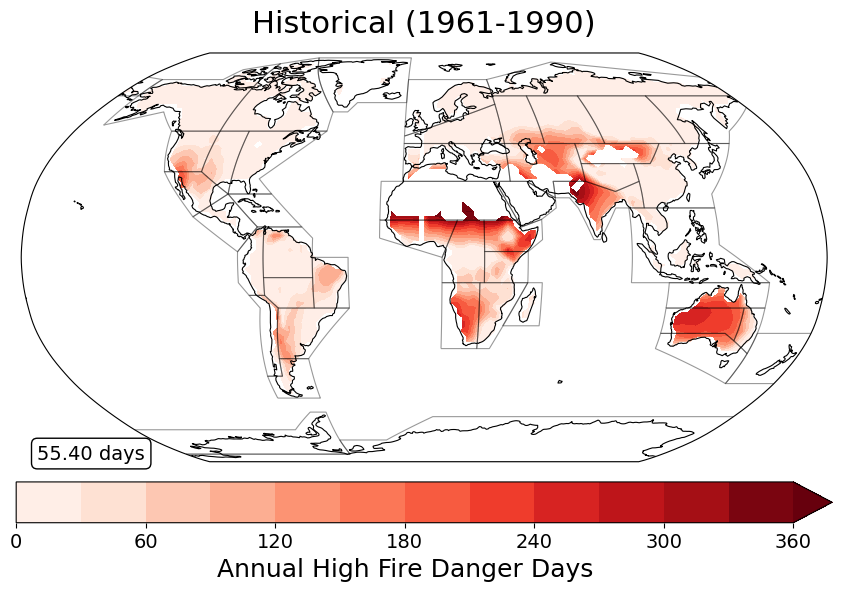

In [29]:
fig, ax = create_global_map(historical_hfd_annual_count_masked.mean('model'), 
                     projection=ccrs.Robinson(),
                     title="Historical (1961-1990)",
                     colormap='Reds',
                     colorbar_title="Annual High Fire Danger Days",
                     textbox_text=f"{historical_hfd_annual_count_masked_globalavg.values.item():.2f} days",
                     figsize=(10.5, 6),
                     vmin=0,
                     vmax=None,
                     extend='max',
                     colorbar_levels=np.arange(0, 360.1, 30),
                     contour_levels=None,
                     hatching='///',
                     regional_boundaries='ar6',
                     hatching_style='overlay',
                     hatching_data=None,
                     show_gridlines=False)

## Anomaly

In [31]:
# Get anomalies of annual frequency

ssp370_hfd_annual_count_anomaly = ssp370_hfd_annual_count - historical_hfd_annual_count
global_hfd_annual_count_anomaly = global_hfd_annual_count - historical_hfd_annual_count
ssp126_hfd_annual_count_anomaly = ssp126_hfd_annual_count - historical_hfd_annual_count
aer126eff_hfd_annual_count_anomaly = global_hfd_annual_count_anomaly - ssp370_hfd_annual_count_anomaly
ghg126eff_hfd_annual_count_anomaly = ssp126_hfd_annual_count_anomaly - global_hfd_annual_count_anomaly

eas_hfd_annual_count_anomaly = eas_hfd_annual_count - ssp370_hfd_annual_count
sas_hfd_annual_count_anomaly = sas_hfd_annual_count - ssp370_hfd_annual_count
afr_hfd_annual_count_anomaly = afr_hfd_annual_count - ssp370_hfd_annual_count
nae_hfd_annual_count_anomaly = nae_hfd_annual_count - ssp370_hfd_annual_count


In [32]:
# Apply masks for global average value (textbox on maps)
# Non-barren land

ssp370_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(ssp370_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
global_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(global_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
ssp126_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(ssp126_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
aer126eff_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(aer126eff_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
ghg126eff_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(ghg126eff_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)

eas_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(eas_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
sas_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(sas_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
afr_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(afr_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)
nae_hfd_annual_count_anomaly_masked_textbox, _ = apply_masks(nae_hfd_annual_count_anomaly, 
                                                         get_significance=False, 
                                                         agreement_threshold=0.0,
                                                         threshold_type='minimum',
                                                         get_land_mask=True,
                                                         baseline_data=None)


In [33]:
# Get latitudinally weighted global average
# Non-barren land (does not need to satisfy significance threshold)

ssp370_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(ssp370_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
global_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(global_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
ssp126_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(ssp126_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
aer126eff_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(aer126eff_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
ghg126eff_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(ghg126eff_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)

eas_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(eas_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
sas_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(sas_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
afr_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(afr_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)
nae_hfd_annual_count_anomaly_masked_globalavg = weighted_horizontal_avg(nae_hfd_annual_count_anomaly_masked_textbox.mean('model'), ensemble = False, time = False)


In [34]:
# Apply masks for filled contour on maps
# Non-barren land and significant

agreement_threshold_val = 0.66
threshold_type_val = 'minimum'

ssp370_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(ssp370_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=ssp370_hfd_annual_count_anomaly)
global_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(global_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=global_hfd_annual_count_anomaly)
ssp126_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(ssp126_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=ssp126_hfd_annual_count_anomaly)
aer126eff_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(aer126eff_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=aer126eff_hfd_annual_count_anomaly)
ghg126eff_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(ghg126eff_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=ghg126eff_hfd_annual_count_anomaly)

eas_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(eas_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=eas_hfd_annual_count_anomaly)
sas_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(sas_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=sas_hfd_annual_count_anomaly)
afr_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(afr_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=afr_hfd_annual_count_anomaly)
nae_hfd_annual_count_anomaly_masked_plot, _ = apply_masks(nae_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=nae_hfd_annual_count_anomaly)


In [37]:
# Apply masks for hatching on maps
# Non-barren land and not significant

agreement_threshold_val = 0.67
threshold_type_val = 'maximum'

ssp370_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(ssp370_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=ssp370_hfd_annual_count_anomaly)
global_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(global_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=global_hfd_annual_count_anomaly)
ssp126_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(ssp126_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=ssp126_hfd_annual_count_anomaly)
aer126eff_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(aer126eff_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=aer126eff_hfd_annual_count_anomaly)
ghg126eff_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(ghg126eff_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=ghg126eff_hfd_annual_count_anomaly)

eas_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(eas_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=eas_hfd_annual_count_anomaly)
sas_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(sas_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=sas_hfd_annual_count_anomaly)
afr_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(afr_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=afr_hfd_annual_count_anomaly)
nae_hfd_annual_count_anomaly_masked_hatching, _ = apply_masks(nae_hfd_annual_count_anomaly, 
                                                         get_significance=True, 
                                                         agreement_threshold=agreement_threshold_val,
                                                         threshold_type=threshold_type_val,
                                                         get_land_mask=True,
                                                         baseline_data=nae_hfd_annual_count_anomaly)

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/hom

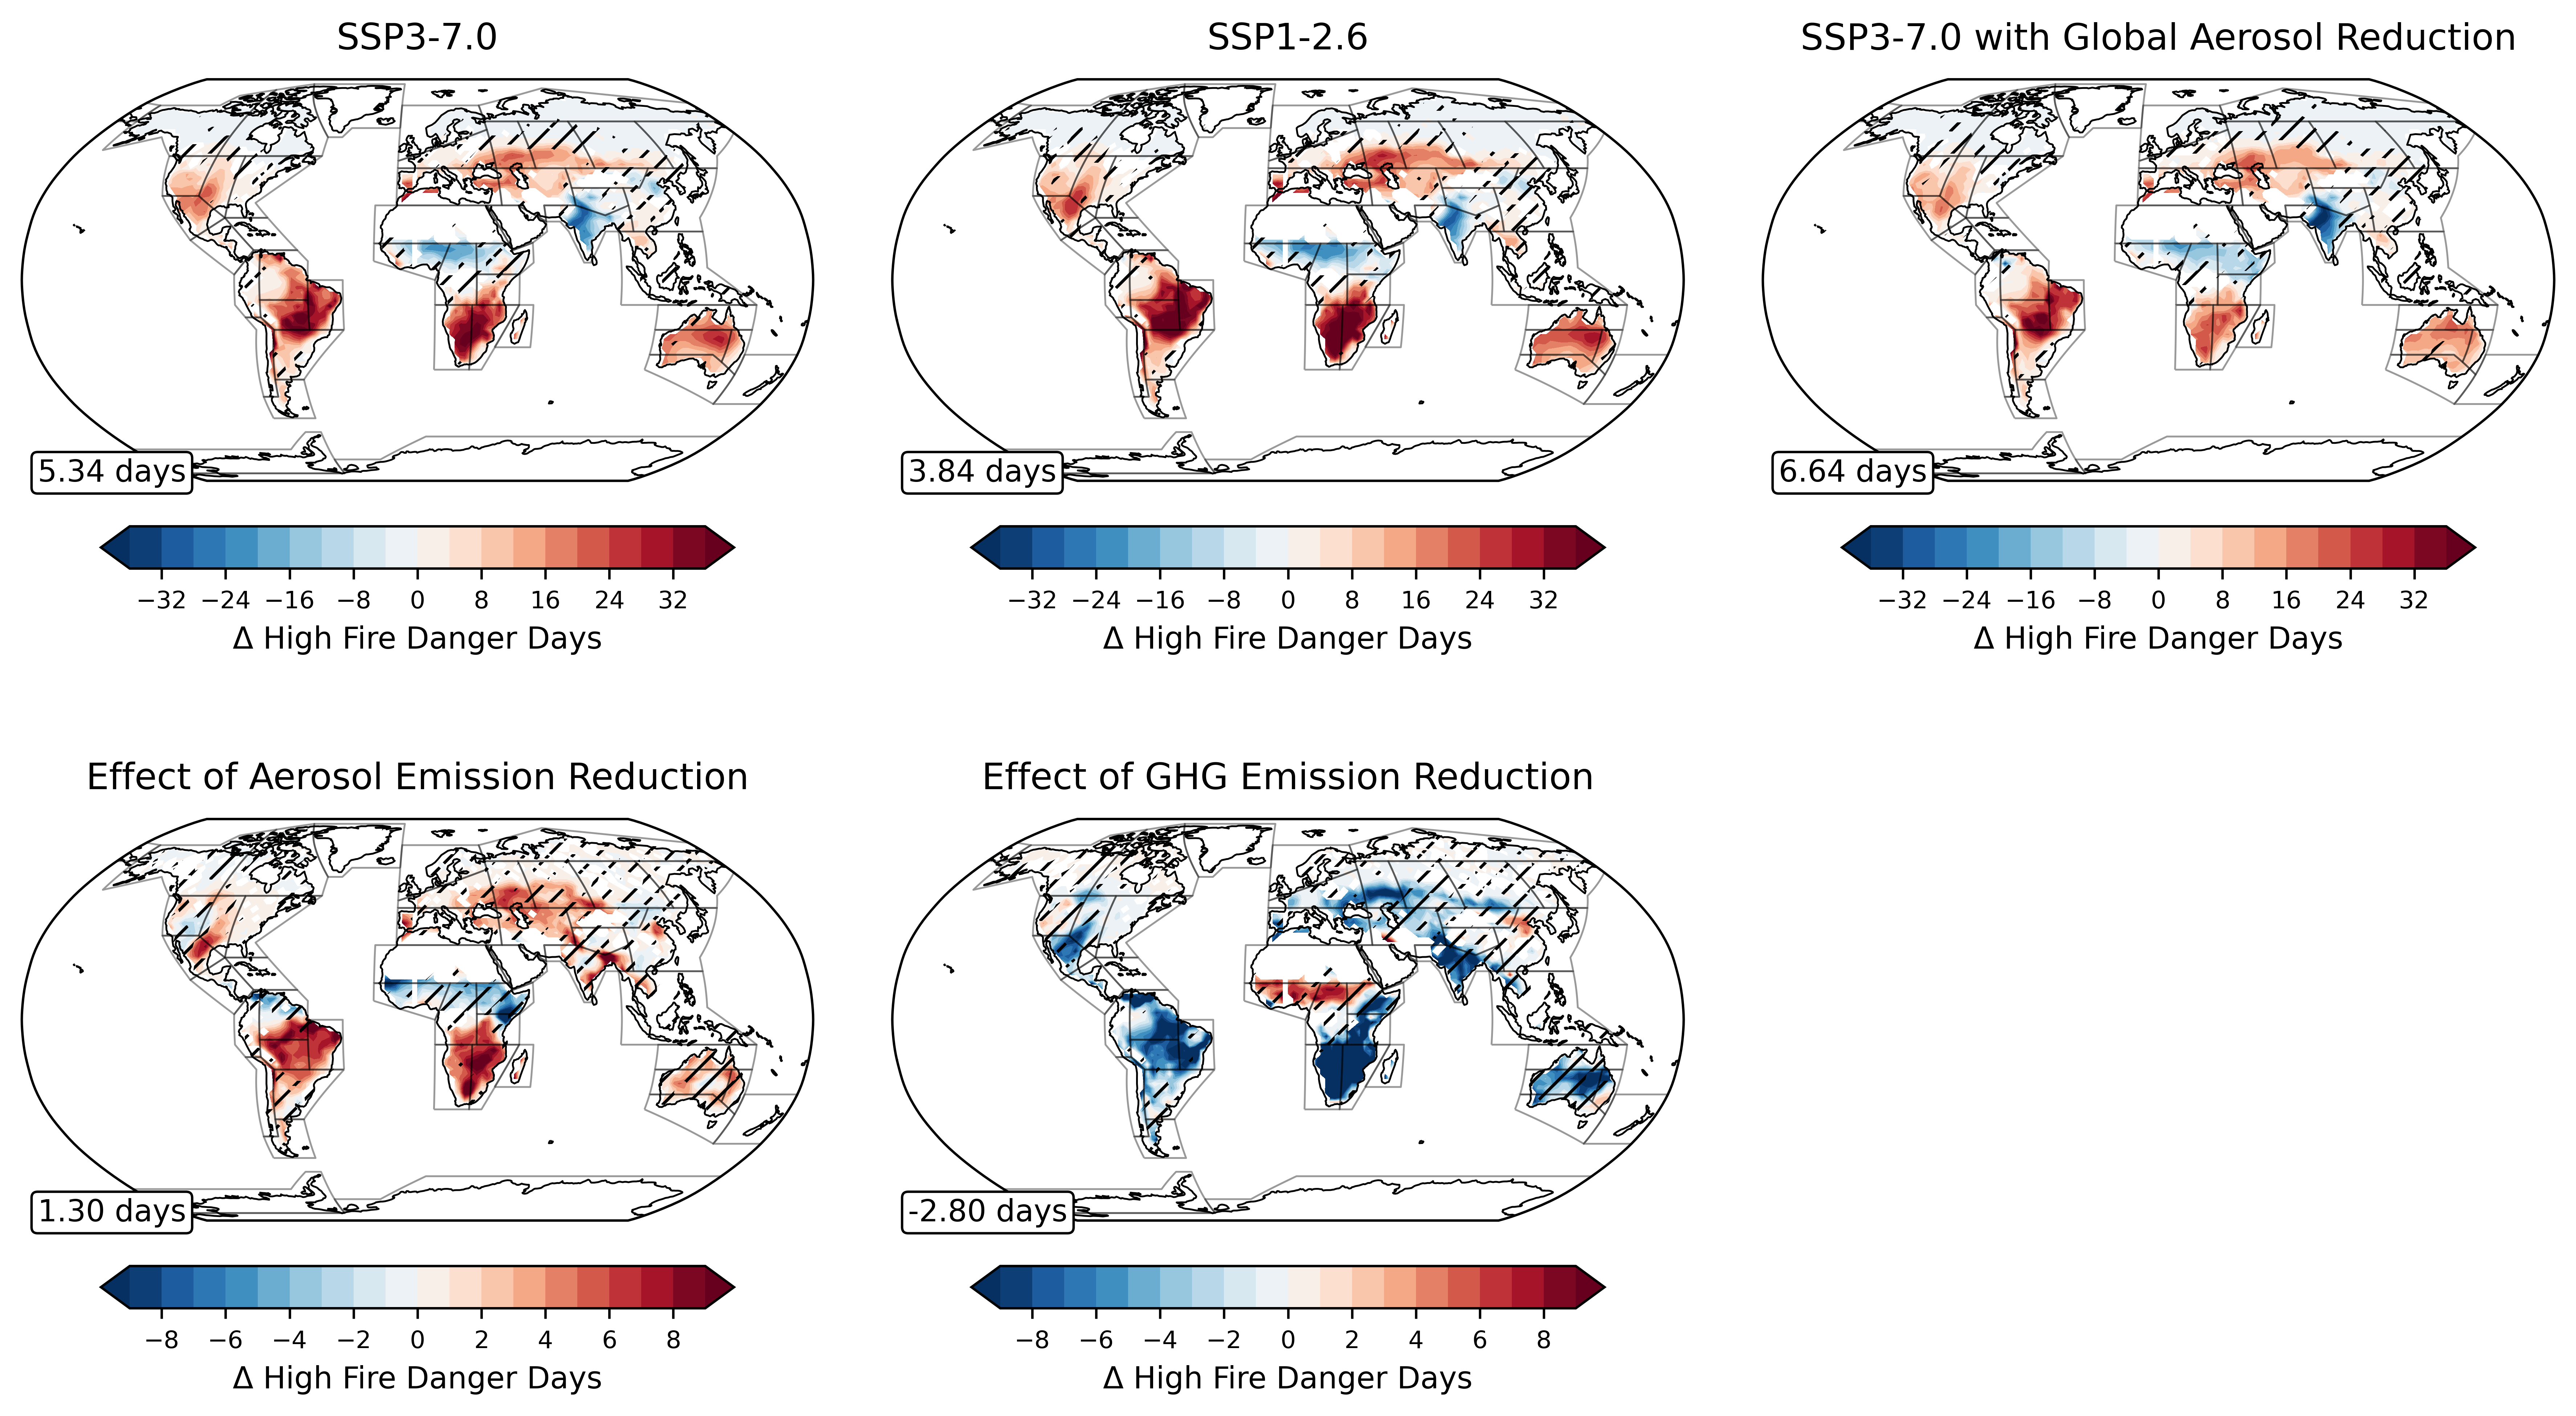

In [38]:
data_list = [ssp370_hfd_annual_count_anomaly_masked_plot.mean('model'), global_hfd_annual_count_anomaly_masked_plot.mean('model'), ssp126_hfd_annual_count_anomaly_masked_plot.mean('model'),
             aer126eff_hfd_annual_count_anomaly_masked_plot.mean('model'), ghg126eff_hfd_annual_count_anomaly_masked_plot.mean('model'),
             ]

title_list = ['SSP3-7.0', 'SSP1-2.6', 'SSP3-7.0 with Global Aerosol Reduction', 'Effect of Aerosol Emission Reduction', 'Effect of GHG Emission Reduction']

textbox_text_list = [f"{ssp370_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{ssp126_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{global_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{aer126eff_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{ghg126eff_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     ]

hatching_data_list = [ssp370_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      ssp126_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      global_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      aer126eff_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      ghg126eff_hfd_annual_count_anomaly_masked_hatching.isel(model=0)
                      ]

vmins_list = [-36, -36, -36, -9, -9]
vmaxs_list = [36, 36, 36, 9, 9]

colorbar_levels_list = [np.arange(-36, 36.1, 4), np.arange(-36, 36.1, 4), np.arange(-36, 36.1, 4), 
                        np.arange(-9, 9.1, 1), np.arange(-9, 9.1, 1)]

fig, axes = create_global_map_grid(
    data_list, 
    rows=2, 
    cols=3,
    main_title=None,
    projection=ccrs.Robinson(),
    titles=title_list,
    colormaps='RdBu_r',
    colorbar_titles="Δ High Fire Danger Days",
    textbox_texts=textbox_text_list,
    # figsize=(20, 14),
    vmins=vmins_list,
    vmaxs=vmaxs_list,
    extends='both',
    colorbar_levels=colorbar_levels_list,
    hatchings='///',
    regional_boundaries='ar6',
    hatching_styles='overlay',
    hatching_data=hatching_data_list,
    show_gridlines=False,
    ramip_regions=False,
)
fig.set_dpi(600)


/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


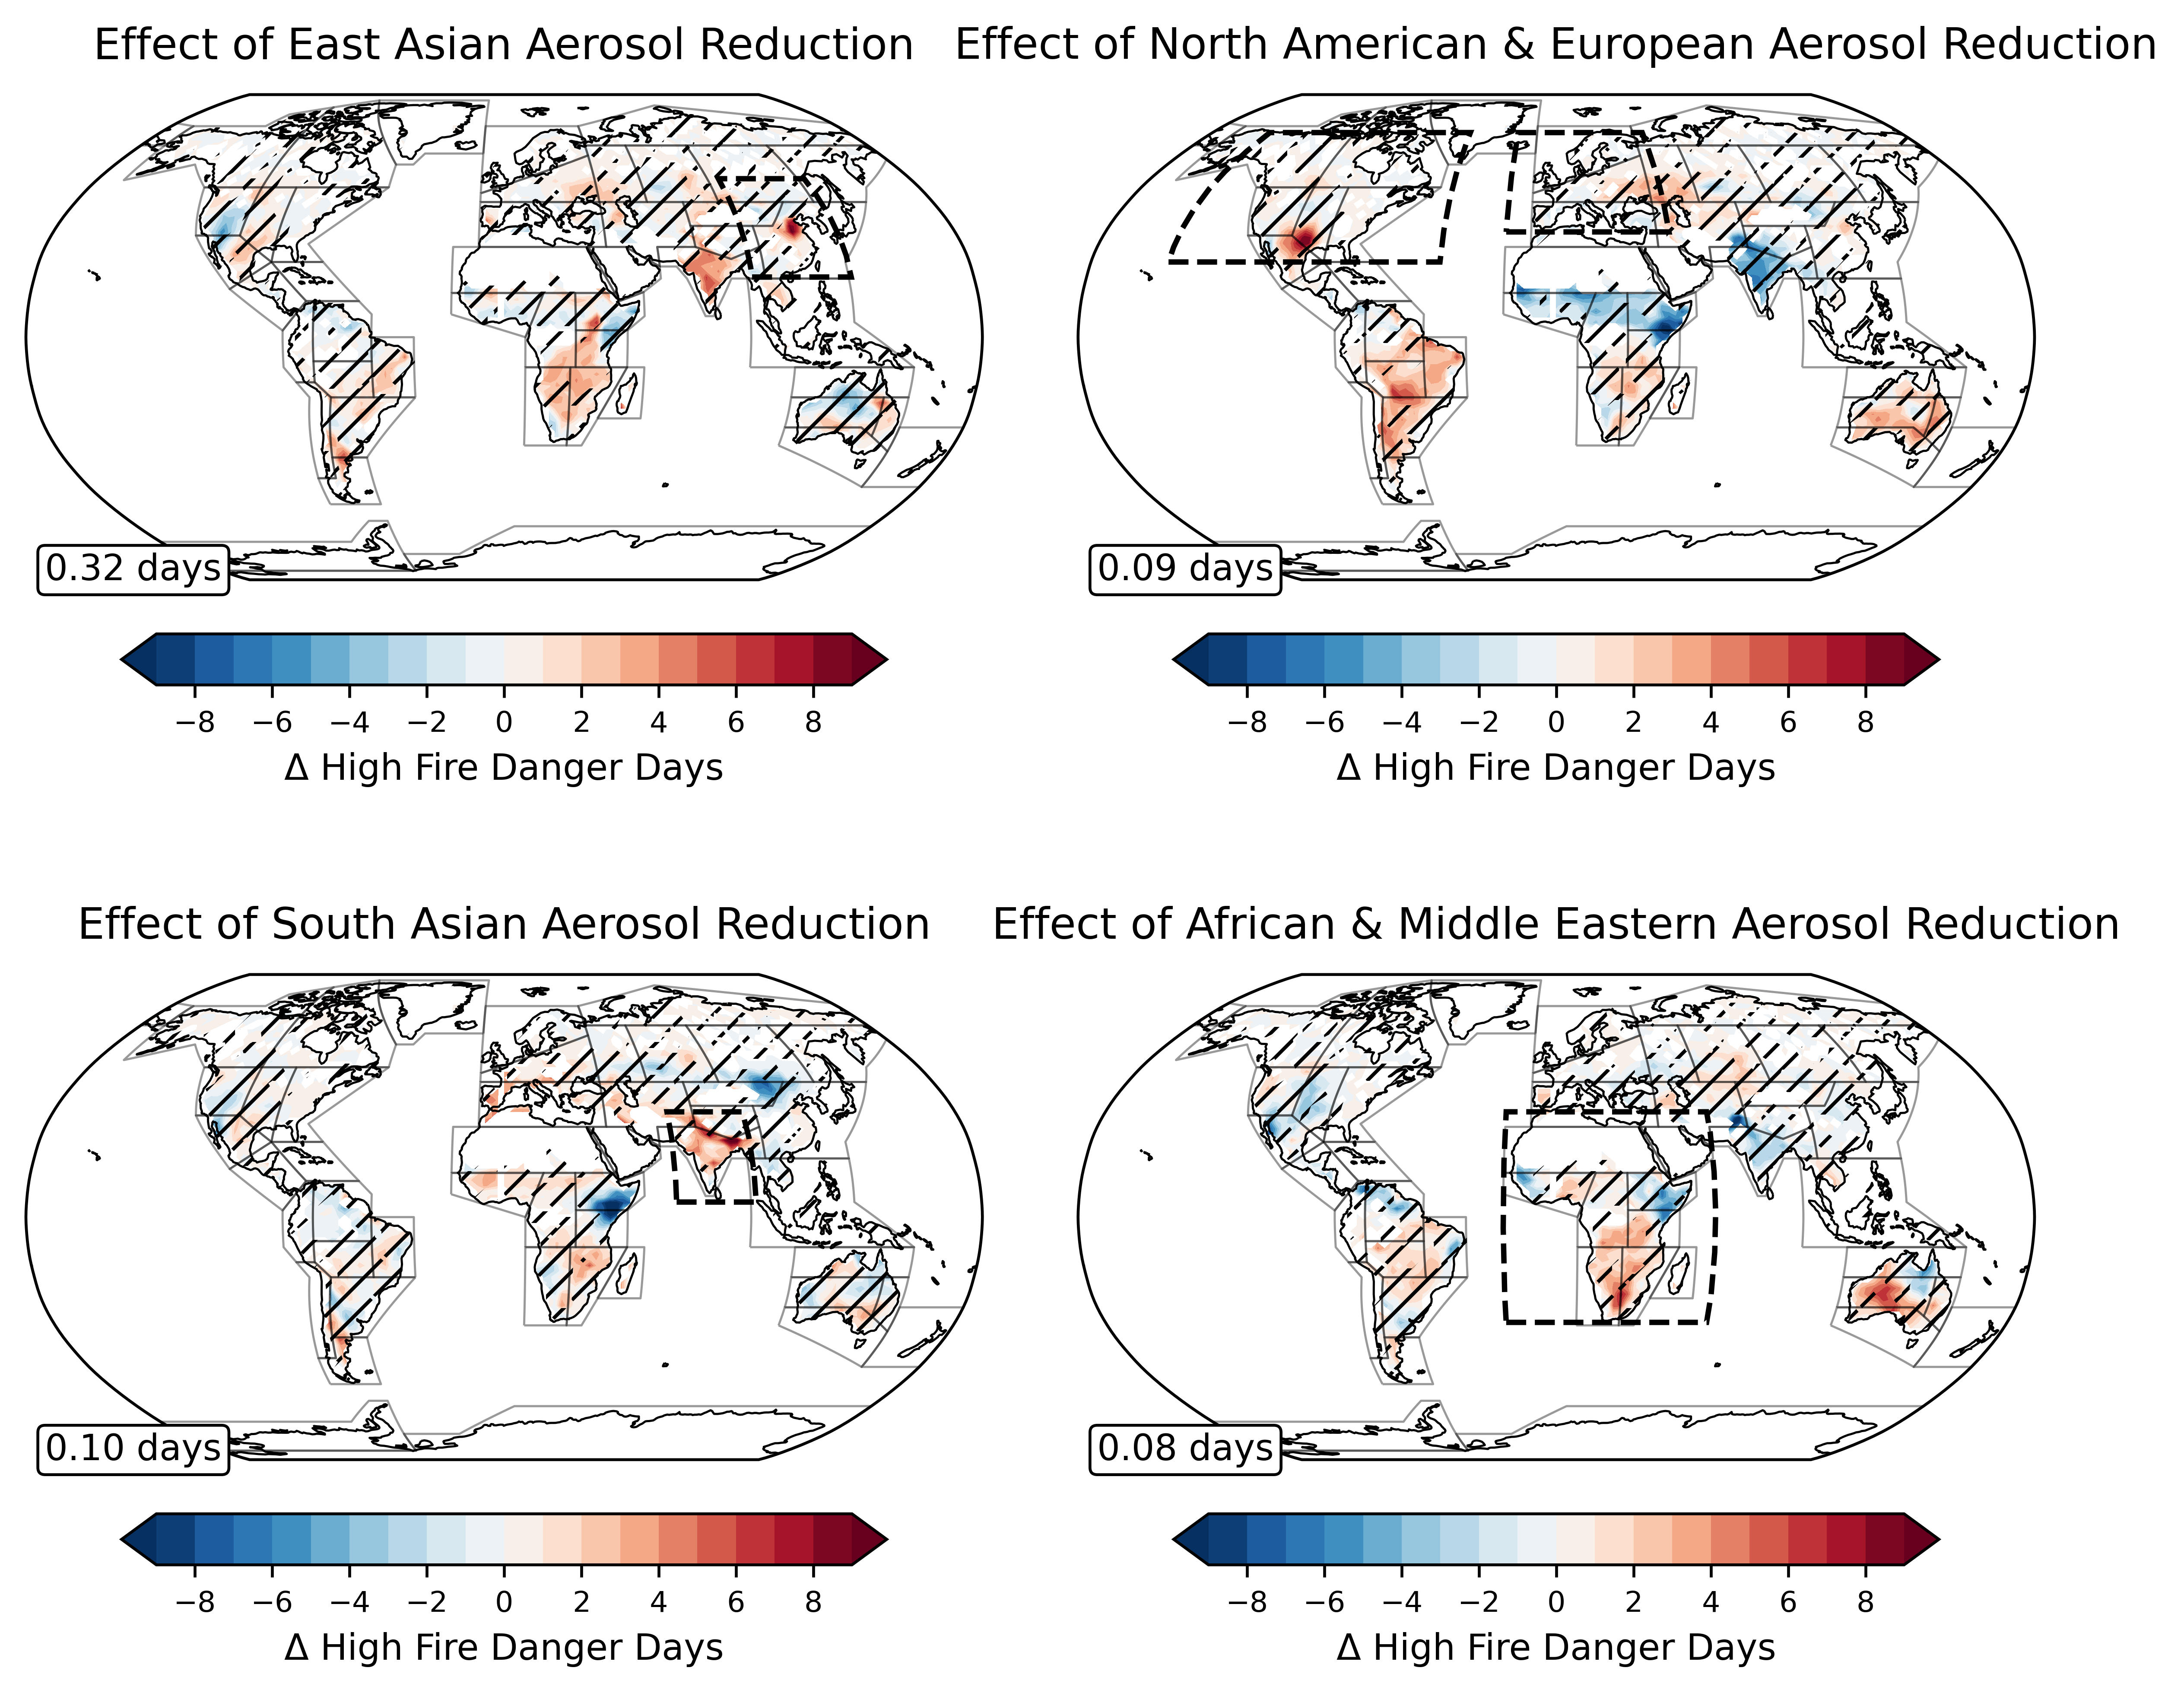

In [81]:
data_list = [eas_hfd_annual_count_anomaly_masked_plot.mean('model'), nae_hfd_annual_count_anomaly_masked_plot.mean('model'), 
             sas_hfd_annual_count_anomaly_masked_plot.mean('model'), afr_hfd_annual_count_anomaly_masked_plot.mean('model'),
             ]

title_list = ['Effect of East Asian Aerosol Reduction', 
              'Effect of North American & European Aerosol Reduction', 
              'Effect of South Asian Aerosol Reduction', 
              'Effect of African & Middle Eastern Aerosol Reduction']

textbox_text_list = [f"{eas_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{nae_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{sas_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     f"{afr_hfd_annual_count_anomaly_masked_globalavg.values.item():.2f} days",
                     ]

hatching_data_list = [eas_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      nae_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      sas_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      afr_hfd_annual_count_anomaly_masked_hatching.isel(model=0),
                      ]

vmins_list = [-9, -9, -9, -9]
vmaxs_list = [9, 9, 9, 9]

colorbar_levels_list = [np.arange(-9, 9.1, 1), np.arange(-9, 9.1, 1),
                        np.arange(-9, 9.1, 1), np.arange(-9, 9.1, 1)]

fig, axes = create_global_map_grid(
    data_list, 
    rows=2, 
    cols=2,
    main_title=None,
    projection=ccrs.Robinson(),
    titles=title_list,
    colormaps='RdBu_r',
    colorbar_titles="Δ High Fire Danger Days",
    textbox_texts=textbox_text_list,
    # figsize=(20, 14),
    vmins=vmins_list,
    vmaxs=vmaxs_list,
    extends='both',
    colorbar_levels=colorbar_levels_list,
    hatchings='///',
    regional_boundaries='ar6',
    hatching_styles='overlay',
    hatching_data=hatching_data_list,
    show_gridlines=False,
    ramip_regions=['east_asia', 'north_america_europe', 'south_asia', 'africa_mideast'],
)
fig.set_dpi(600)
